In [1]:
import sys
sys.path.append("..")

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

from herec.reader import *

In [2]:
readers = {
    "ML100K": ML100K(),
    "ML1M_IMPLICIT": ML1M(),
    "Ciao": Ciao(),
    "Ciao_PART": Ciao_PART(),
    "Yelp": Yelp(),
}

## Basic Staristics

In [3]:
def giniCoefficient(values):

    # Setup
    values = np.array(list(sorted(values)))
    n = len(values)

    # Plot Lorenz Curve
    # fig, ax = plt.subplots(figsize=(2.5, 2.5))
    # ax.plot(np.arange(1, len(values)+1), values.cumsum() / values.sum())
    # plt.show()

    # Gini Coefficient
    return (2 * np.sum(values * np.arange(1, n+1))) / (n * values.sum()) - (n + 1) / n

ML100K
User #: 706.6666666666666
Item #: 1594.0
Interaction #: 70119.66666666667
Density #: 0.062392520115277496


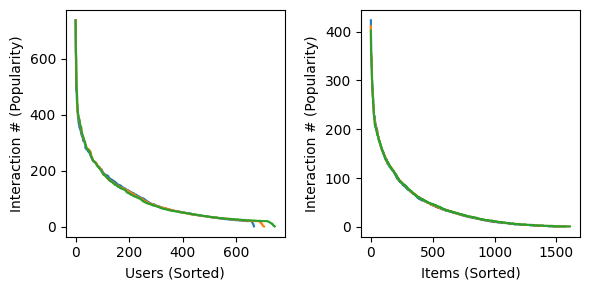

Novelty: 3.4174165260151743
Gini Coefficient: 0.6162587011417502


---

ML1M_IMPLICIT
User #: 5047.666666666667
Item #: 3655.3333333333335
Interaction #: 739005.6666666666
Density #: 0.04005956854621557


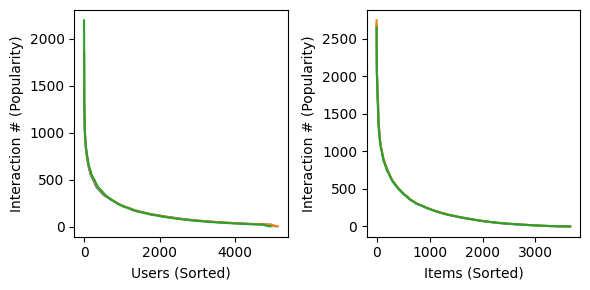

Novelty: 3.825312126821783
Gini Coefficient: 0.6346567525711778


---

Ciao
User #: 6170.0
Item #: 72141.0
Interaction #: 185646.33333333334
Density #: 0.00041772886473813767


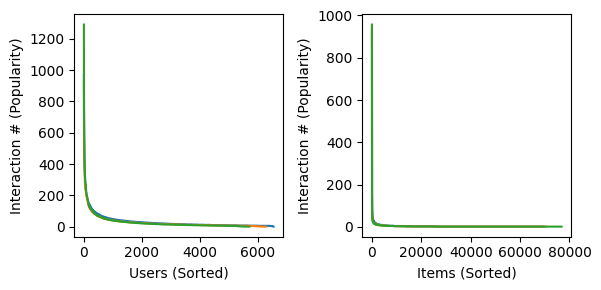

Novelty: 10.53908197227008
Gini Coefficient: 0.5234994027820605


---

Ciao_PART
User #: 1716.6666666666667
Item #: 10249.666666666666
Interaction #: 19995.333333333332
Density #: 0.0011327646185020671


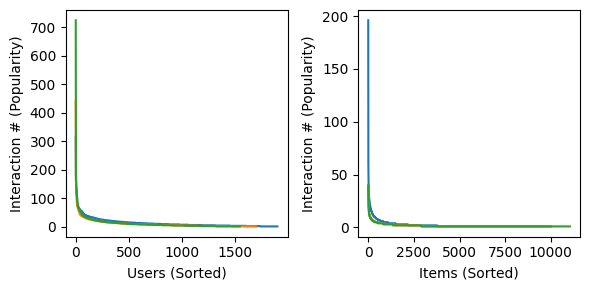

Novelty: 9.417427396051144
Gini Coefficient: 0.3973192207255567


---

Yelp
User #: 24647.333333333332
Item #: 9809.666666666666
Interaction #: 135194.0
Density #: 0.000582904448361313


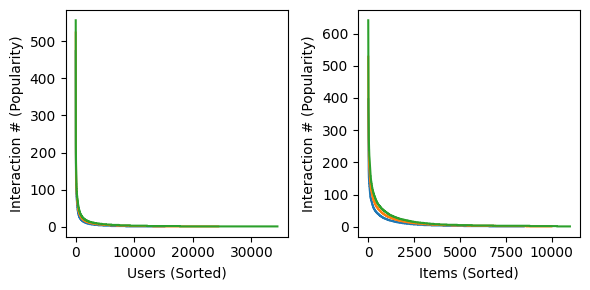

Novelty: 9.805899271617376
Gini Coefficient: 0.691048282285823


---

In [4]:
for datasetName, reader in readers.items():
    
    print(datasetName)
    DATA = [reader.get(seed, "test") for seed in range(3)]

    # Basic Statistic
    userNum = np.array([DATA[seed]["user_num"] for seed in range(3)])
    print("User #:", np.mean(userNum))
    itemNum = np.array([DATA[seed]["item_num"] for seed in range(3)])
    print("Item #:", np.mean(itemNum))
    interactionNum = np.array([DATA[seed]["df_TRAIN"].height for seed in range(3)])
    print("Interaction #:", np.mean(interactionNum))
    density = interactionNum / (userNum * itemNum)
    print("Density #:", np.mean(density))

    # User/Item Popularity
    fig, ax = plt.subplots( 1, 2, figsize=(6, 3) )
    plt.subplots_adjust(wspace=0.4)
    for seed in range(3):
        values = DATA[seed]["df_TRAIN"].get_column("user_id").value_counts().sort("count", descending=True).get_column("count")
        ax[0].plot( range(len(values)), values )
        ax[0].set_xlabel("Users (Sorted)")
        ax[0].set_ylabel("Interaction # (Popularity)")
        values = DATA[seed]["df_TRAIN"].get_column("item_id").value_counts().sort("count", descending=True).get_column("count")
        ax[1].plot( range(len(values)), values )
        ax[1].set_xlabel("Items (Sorted)")
        ax[1].set_ylabel("Interaction # (Popularity)")
    plt.tight_layout()
    plt.show()

    # Novelty
    novelty = []
    for seed in range(3):
        p = DATA[seed]["df_TRAIN"].group_by("item_id").count().with_columns(
            pl.col("count") / DATA[seed]["df_TRAIN"].get_column("user_id").n_unique()
        )
        p = dict(zip(*p))
        p = {itemId: (p[itemId] if itemId in p.keys() else 0) for itemId in range(DATA[seed]["item_num"])}
        score = np.array([
            (- np.log2([p[itemId] for itemId in trueIdList if itemId != -1])).mean()
            for trueIdList in DATA[seed]["df_EVALUATION"].group_by("user_id").agg("item_id").get_column("item_id").to_list()
        ])
        novelty.append( score[score != np.inf].mean() )
    print("Novelty:", np.mean(novelty))

    # Gini Coefficient
    gini = np.array([giniCoefficient( DATA[seed]["df_TRAIN"].group_by("item_id").count().get_column("count") ) for seed in range(3)])
    print("Gini Coefficient:", np.mean(gini))

    display(Markdown('---'))

## Rating Count (on TRAIN Subset)

ML100K


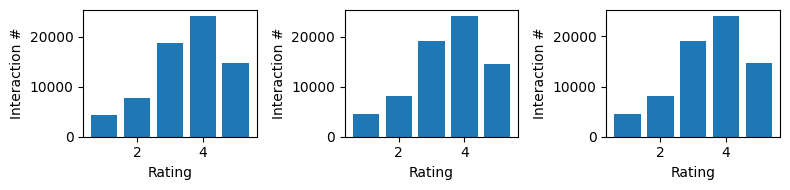

ML1M_IMPLICIT


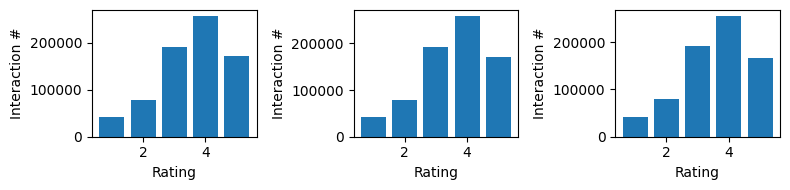

Ciao


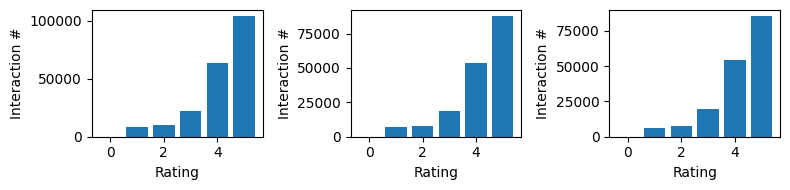

Ciao_PART


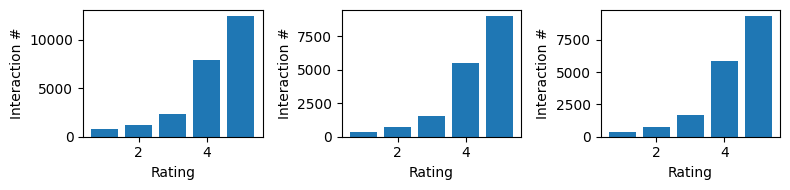

Yelp


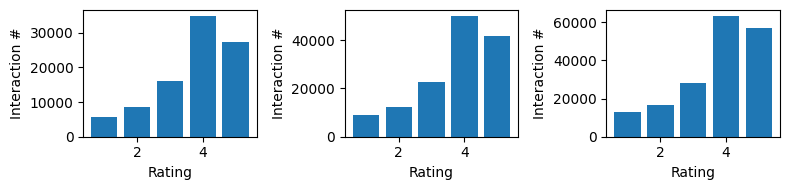

In [5]:
for datasetName, reader in readers.items():

    print(datasetName)
    DATA = [reader.get(seed, "test") for seed in range(3)]

    fig, ax = plt.subplots(1, 3, figsize=(8, 2), sharex=True, sharey=False)
    for seed in range(3):
        count_df = DATA[seed]["df_TRAIN"].get_column("rating").value_counts()
        ax[seed].bar( count_df.get_column("rating"), count_df.get_column("count") )
        ax[seed].set_xlabel("Rating")
        ax[seed].set_ylabel("Interaction #")
    plt.tight_layout()
    plt.show()